### Load Library

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

### Load in Test and Validation Data

Note: Labels have to be converted to integer for ROC AUC computation

In [5]:
## Load in Training Set
X_train_path = "data/new_preprocessed_data/training/X_train_enc.parquet"
X_train = pd.read_parquet(X_train_path)

y_train_path = "data/new_preprocessed_data/training/y_train.parquet"
y_train = pd.read_parquet(y_train_path)
y_train = pd.DataFrame(y_train['label'].astype(int)) ## convert labels to int for roc auc calculation


## Load in Test Set
X_test_path = "data/new_preprocessed_data/test/X_test_enc.parquet"
X_test = pd.read_parquet(X_test_path)

y_test_path = "data/new_preprocessed_data/test/y_test.parquet"
y_test = pd.read_parquet(y_test_path)
y_test = pd.DataFrame(y_test['label'].astype(int)) ## convert labels to int for roc auc calculation


## Load in Validation Set
X_val_path = "data/new_preprocessed_data/validation/X_val_enc.parquet"
X_val = pd.read_parquet(X_val_path)

y_val_path = "data/new_preprocessed_data/validation/y_val.parquet"
y_val = pd.read_parquet(y_val_path)
y_val = pd.DataFrame(y_val['label'].astype(int)) ## convert labels to int for roc auc calculation

### Create Functions Needed For :

- Random Forest Classification
- Hyperparameter Tuning
- Feature Selection (SelectFromModel or RFE)

Link to understand RandomForestClassifier different parameters:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [12]:
## function for classification
def random_forest(x_train, y_train, x_val, y_val, x_test, y_test,
                    n_estimators = 100, max_features = "sqrt", max_depth = None,
                    min_samples_split = 2, min_samples_leaf = 1, bootstrap = True):
    ## create classifier
    clf = RandomForestClassifier(random_state = 1, n_estimators = n_estimators, max_features = max_features, 
                                    max_depth = max_depth, min_samples_split = min_samples_split, 
                                    min_samples_leaf = min_samples_leaf, bootstrap = bootstrap)

    ## train the model
    clf.fit(x_train, y_train)

    ## get validation and test predicition
    y_val_pred = clf.predict(x_val)
    print('Accuracy of random forest classifier on validation set: {:.2f}'.format(accuracy_score(y_val, y_val_pred)))
   
    y_test_pred = clf.predict(x_test)
    print('Accuracy of random forest classifier on test set: {:.2f}'.format(accuracy_score(y_test, y_test_pred)))

    ## define metrics for roc
    y_test_pred_proba = clf.predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    rf_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    
    ## create roc curve   
    plt.figure()
    plt.plot(fpr, tpr, label = 'Random Forest Classifier (area = %0.2f)' % rf_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc = "lower right")
    plt.show()

    ## define metric for precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
    auc_precision_recall = auc(recall, precision)

    ## create pr curve   
    plt.figure()
    plt.plot(recall, precision, label = 'Random Forest Classifier (area = %0.2f)' % auc_precision_recall)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall')
    plt.legend(loc = "lower right")
    plt.show()

In [21]:
## defining param_grid

# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(200, 301, 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(10, 101, 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [8]:
## function for hyperparameter tuning

def params_tuning(param_grid, X_train, y_train):
    rf = RandomForestClassifier(random_state = 1)

    ## random search of parameters using 3 fold cross validation
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 50, cv = 3, random_state = 7, n_jobs = -1)
    rf_random.fit(X_train, y_train)

    return rf_random.best_params_

In [29]:
## function for feature Selection, method can be chosen using SelectFromModel or RFE

def var_selection(X_train, y_train, model, method = SelectFromModel):
    sel = method(model)
    sel.fit(X_train, y_train)

    return X_train.columns[(sel.get_support())]

## Stages to Perform

1. Classification on all columns
2. Classification on all columns with hyperparameter tuning
3. Feature selection
4. Classification on selected features
5. Classification on selected features with hyperparameter tuning

## Stage 1: Classification on all columns

<ipython-input-12-c0b770a1036b>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Accuracy of random forest classifier on validation set: 0.72
Accuracy of random forest classifier on test set: 0.72


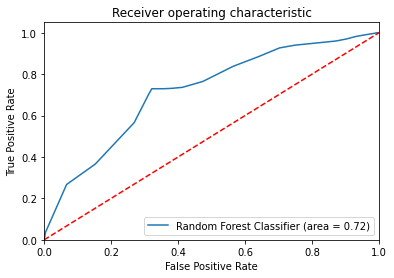

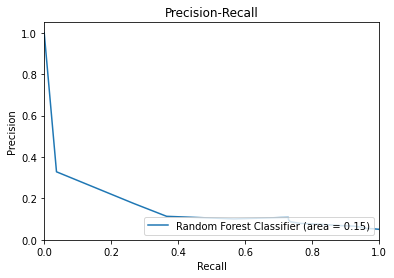

In [13]:
random_forest(X_train, y_train, X_val, y_val, X_test, y_test)

## Stage 2: Classification on all columns with hyperparameter tuning

In [22]:
best_param_all = params_tuning(random_grid, X_train, y_train)
best_param_all

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'n_estimators': 240,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 55,
 'bootstrap': False}

<ipython-input-12-c0b770a1036b>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy of random forest classifier on validation set: 0.95
Accuracy of random forest classifier on test set: 0.95


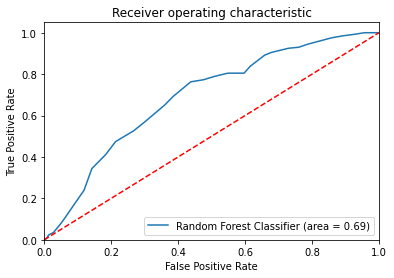

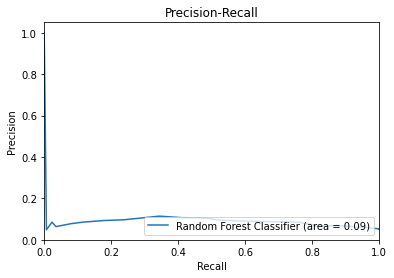

In [23]:
random_forest(X_train, y_train, X_val, y_val, X_test, y_test,
                n_estimators = 240, max_features = "auto", max_depth = 55,
                min_samples_split = 2, min_samples_leaf = 1, bootstrap = False)

## Stage 3: Feature Selection

In [30]:
rf_fs = RandomForestClassifier(random_state = 1)
rf_fs.fit(X_train, y_train)

best_var = var_selection(X_train, y_train, rf_fs)
best_var = list(best_var)
best_var

<ipython-input-30-9ed9b3c1cb86>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fs.fit(X_train, y_train)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:355: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


['reads_count',
 'std_-1_25',
 'std_-1_50',
 'std_-1_75',
 'std_-1_mean',
 'mean_-1_25',
 'mean_-1_50',
 'mean_-1_75',
 'mean_-1_mean',
 'dwelling_time_0_25',
 'dwelling_time_0_50',
 'dwelling_time_0_75',
 'dwelling_time_0_mean',
 'std_0_25',
 'std_0_50',
 'std_0_75',
 'std_0_mean',
 'mean_0_25',
 'mean_0_50',
 'mean_0_75',
 'mean_0_mean',
 'std_+1_25',
 'std_+1_50',
 'std_+1_75',
 'std_+1_mean',
 'mean_+1_25',
 'mean_+1_50',
 'mean_+1_75',
 'mean_+1_mean',
 'position_1_G',
 'position_5_T']

## Stage 4: Classification on selected features

<ipython-input-12-c0b770a1036b>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Accuracy of random forest classifier on validation set: 0.95
Accuracy of random forest classifier on test set: 0.95


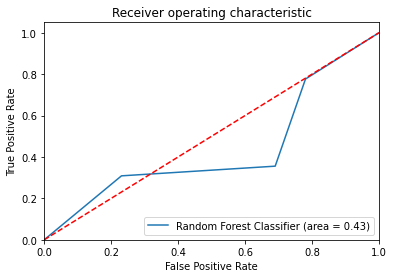

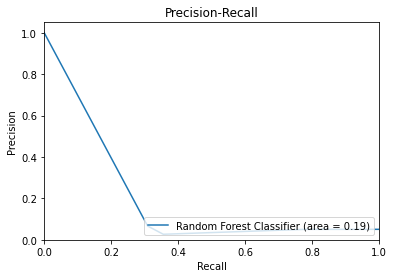

In [34]:
random_forest(X_train[best_var], y_train, X_val[best_var], y_val, X_test[best_var], y_test)

## Stage 5: Classification on selected features with hyperparameter tuning

In [36]:
best_param_fs = params_tuning(random_grid, X_train[best_var], y_train)
best_param_fs

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'n_estimators': 235,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 35,
 'bootstrap': False}

<ipython-input-12-c0b770a1036b>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy of random forest classifier on validation set: 0.95
Accuracy of random forest classifier on test set: 0.95


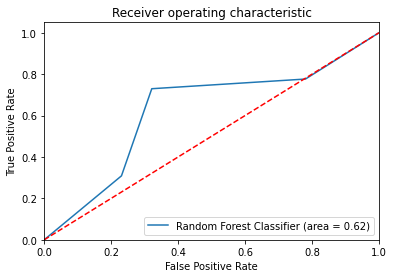

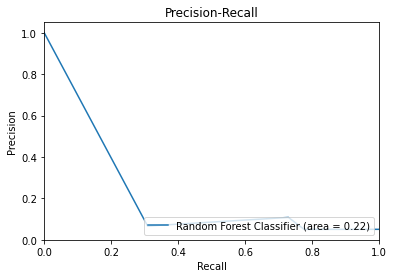

In [37]:
random_forest(X_train[best_var], y_train, X_val[best_var], y_val, X_test[best_var], y_test,
                n_estimators = 235, max_features = "auto", max_depth = 35,
                min_samples_split = 5, min_samples_leaf = 2, bootstrap = False)